This notebook includes a first sketch of the ShorelineNet implementation in pytorch.

In particular I want to achieve the following:
* config loading
* network saving & loading
* try to wrap everything in classes
* where possible, use type annotations
* experiment with MC dropout & posterior estimation

15 Jan: loaded images

16 Jan: augmentation pipeline

17 Jan: Create network architecture & load pre-trained encoder

18 Jan: Set up loss function & training loop

10 Feb: complete training loop & checked that results are reproduced
    Training Loss reaches 0.0035 in around 100 epochs, which is better than previous results due to nearest interpolation of masks

11 Feb: Separate Training & Validation sets, make GPU training time faster, add evaluation methods on accuracy

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from tqdm.notebook import tqdm
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch import ones_like, zeros_like
from torchsummary import summary

ENV = 'colab' # 'local'

if ENV == 'colab':
  from google.colab import drive
  drive.mount("/content/drive/", force_remount=True)

  # copy dataset to local env
  if 'data' not in os.listdir():
    !cp "/content/drive/My Drive/project_online/dataset/mastr.zip" .
    !unzip -q 'mastr.zip' -d data
    !rm 'mastr.zip'

  mastr_path = '/content/data/'
  module_dir = "/content/drive/My Drive/ShorelineNet_pytorch/"

elif ENV == 'local':
  mastr_path = '../../project_offline/Dataset/MaSTr1325/'
  module_dir = '..'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# append local module to path
module_path = os.path.abspath(os.path.join(module_dir))
if module_path not in sys.path:
    sys.path.append(module_path)


Mounted at /content/drive/


## Import modules

### Dataset

In [ ]:
# import local modules
# from utils.transforms import ToTensor, ToDevice, HFlip, Rotation, HueSatCon, Crop, Resize
# from helper.visualization import ImageDisplayer, show_features
# from utils.mastr_dataset import MastrDataset
# from model.unet_mobilenetv2 import Unet_MobileNetV2, Unet_MobileNetV2_Decoder, Encoder_feature_extractor

import os
# from skimage import io
from torchvision.io import read_image
from torch.utils.data import Dataset


class MastrDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.mask_dir = mask_dir
        self.img_dir = img_dir
        self.transform = transform

        self.img_file_names = os.listdir(img_dir)

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_file_names[idx])
        mask_path = os.path.join(
            self.mask_dir, self.img_file_names[idx].replace(".jpg", "m.png"))

        # image = io.imread(img_path)
        # mask = io.imread(mask_path)

        # NOTE: image format: (C, W, H)

        image = read_image(img_path)
        mask = read_image(mask_path)

        # NOTE: image format(C, W, H)

        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)

        return sample

class MastrDataset_fromMemory(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        image = self.X[idx]
        mask = self.y[idx]
        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        return sample


### Transformations

In [ ]:
import torch
import random
from torchvision import transforms

# Flip, Hue & sat, Rotation, Scaling, Resize, Normalize

# Only on tensors!
class HFlip(object):
    def __init__(self, prob):
        self.prob = prob
        self.HFlip = transforms.RandomHorizontalFlip(1)

    def __call__(self, data):
        image, mask = data['image'], data['mask']
        p = random.random()
        if p < self.prob:
            image = self.HFlip(image)
            mask = self.HFlip(mask)

        return {'image': image, 'mask': mask}

class HueSatCon(object):
    def __init__(self, brightness, contrast, saturation, hue, prob):
        self.prob = prob
        self.hue_transform = transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def __call__(self, data):
        image, mask = data['image'], data['mask']
        p = random.random()
        if p < self.prob:
            image = self.hue_transform(image)
        return {'image': image, 'mask': mask}


class Rotation(object):
    def __init__(self, angle, prob=1):
        self.prob = prob
        self.angle = angle

    def __call__(self, data):
        image, mask = data['image'], data['mask']
        rot_angle = (random.random()*2-1) * self.angle
        p = random.random()
        if p < self.prob:
            image = transforms.functional.rotate(image, rot_angle, expand=True)
            mask = transforms.functional.rotate(mask, rot_angle, expand=True, fill=3)
        return {'image': image, 'mask': mask}

class Crop(object):
    def __init__(self, crop_percentage):
        self.crop_percentage = crop_percentage

    def __call__(self, data):
        image, mask = data['image'], data['mask']
        img_dim = image.shape[1]
        height = int(self.crop_percentage * img_dim)
        width = int(self.crop_percentage * img_dim)
        left = int(random.random() * ((1-self.crop_percentage)/2) * img_dim)
        top = int(random.random() * ((1-self.crop_percentage)/2) * img_dim)

        image = transforms.functional.crop(image, top, left, height, width)
        mask = transforms.functional.crop(mask, top, left, height, width)

        return {'image': image, 'mask': mask}

class Resize(object):
    def __init__(self, size):
        self.size = size
        self.resize_image = transforms.Resize(size, transforms.InterpolationMode.BILINEAR)
        self.resize_mask = transforms.Resize(size, transforms.InterpolationMode.NEAREST) #nearest-exact?

    def __call__(self, data):
        image, mask = data['image'], data['mask']
        image = self.resize_image(image)
        mask = self.resize_mask(mask)

        return {'image': image, 'mask': mask}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, data):
        image, mask = data['image'], data['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        # image = image.transpose((2, 0, 1))
        # image = torch.from_numpy(image).to(dtype=torch.float32) / 255.0 # normalize
        # mask = torch.from_numpy(mask).unsqueeze(0).to(dtype=torch.float32)

        image = image / 255.0
        mask = torch.where(mask == 4, torch.ones_like(mask)*3, mask)

        return {'image': image, 'mask': mask}

# class ToDevice(object):
#     """move data to cpu / gpu"""
#     def __init__(self, device):
#         self.device = device
#     def __call__(self, data):
#         image, mask = data['image'], data['mask']

#         image.to(self.device)
#         mask.to(self.device)

#         return {'image': image, 'mask': mask}

### Model Definition

In [ ]:
import torch
import torch.nn as nn

class Unet_MobileNetV2(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        # attaches hooks to the encoder
        self.feature_extractor = Encoder_feature_extractor(self.encoder)
        # dummy forward pass

        dummy_input = torch.rand((2, 3, 224, 224))
        self.encoder(dummy_input)

        self.decoder.load(self.feature_extractor)

    def forward(self, x):
        self.encoder(x)
        out = self.decoder(self.feature_extractor.features)
        return out

# Conv2DTranspose => Batchnorm => Dropout => Relu
class Unet_MobileNetV2_Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.loaded = False

    def load(self, encoder_features):
        deconv_outputs = [512, 256, 128, 64, 3]
        # print(encoder_features.features)

        in_channels = encoder_features.features['skip_5'].shape[1]

        self.block_1 = self.deconv_block(in_channels, deconv_outputs[0], 3, 2, 0.5)
        in_channels = deconv_outputs[0] + encoder_features.features['skip_4'].shape[1]

        self.block_2 = self.deconv_block(in_channels, deconv_outputs[1], 3, 2, 0)
        in_channels = deconv_outputs[1] + encoder_features.features['skip_3'].shape[1]

        self.block_3 = self.deconv_block(in_channels, deconv_outputs[2], 3, 2, 0)
        in_channels = deconv_outputs[2] + encoder_features.features['skip_2'].shape[1]

        self.block_4 = self.deconv_block(in_channels, deconv_outputs[3], 3, 2, 0)
        in_channels = deconv_outputs[3] + encoder_features.features['skip_1'].shape[1]

        self.final_layer = nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.block_5 = self.deconv_block(in_channels, deconv_outputs[4], 3, 2)

        self.loaded = True

    def deconv_block(self, in_channels, out_channels, kernel_size, stride, dropout=0.5):
        conv_transpose_2d = nn.ConvTranspose2d(
                in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1)
        torch.nn.init.xavier_normal_(conv_transpose_2d.weight)
        return nn.Sequential(
            conv_transpose_2d,
            nn.BatchNorm2d(num_features=out_channels),
            nn.Dropout(p=dropout),
            nn.ReLU()
        )

    def forward(self, input):

        assert(self.loaded==True)

        x = input['skip_5']
        x = self.block_1(x)
        x = torch.cat((x, input['skip_4']), dim=1)
        x = self.block_2(x)
        x = torch.cat((x, input['skip_3']), dim=1)
        x = self.block_3(x)
        x = torch.cat((x, input['skip_2']), dim=1)
        x = self.block_4(x)
        x = torch.cat((x, input['skip_1']), dim=1)
        x = self.final_layer(x)

        return x

class Encoder_feature_extractor():
    def __init__(self, encoder):
        self.features = {}

        layers = {
            "skip_1": encoder.features[2].conv[0][2],
            "skip_2": encoder.features[4].conv[0][2],
            "skip_3": encoder.features[7].conv[0][2],
            "skip_4": encoder.features[14].conv[0][2],
            "skip_5": encoder.features[17]
        }


        # if we extract based on blocks this is what we'd get instead:
        # layers = {
        #     "block_1": mobileNet.features[1],
        #     "block_2": mobileNet.features[3],
        #     "block_3": mobileNet.features[6],
        #     "block_4": mobileNet.features[13],
        #     "block_5": mobileNet.features[17]
        # }

        for (name, layer) in layers.items():
            layer.register_forward_hook(self._get_feature(name))

    def _get_feature(self, name):
        def hook(model, input, output):
            self.features[name] = output
        return hook

### Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

class ImageDisplayer():
    def __init__(self, images, labels, predictions=None):
        self.images = images.cpu()
        self.labels = labels.cpu()
        self.predictions = predictions

    def show_sample(self, idx=None):
        if idx is None:
            idx = np.random.randint(0, len(self.images))
        if len(self.images.shape) == 3:
            self.images = self.images.unsqueeze(0)
            self.labels = self.labels.unsqueeze(0)

        img = self.images[idx].permute(1, 2, 0)
        # labels = self.labels[idx].permute(1, 2, 0)
        labels = self.labels[idx].squeeze()

        plt.figure(figsize=(16, 8))

        plt.subplot(1, 2, 1)
        plt.title('Input Image')
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('True Mask')
        plt.imshow(labels)
        plt.axis('off')

        plt.tight_layout()


def show_features(features, num_images=20, offset=0):
    i = offset
    n = num_images
    plt.figure(figsize=(20, 4))
    plt.axis('off')
    plt.imshow(make_grid(features.detach().permute(1, 0, 2, 3)[i:n+i], nrow=10).permute(1,2,0));

### Load all data into memory

In [ ]:
from torchvision.io import read_image

# load all of training data into memory
def load_mastr(img_dir, mask_dir):
    '''Load all data into memory '''
    img_file_names = os.listdir(img_dir)
    n = len(img_file_names)
    # preallocate tensor memory
    X = torch.zeros((n, 3, 384, 512), dtype=torch.float32, device=device, requires_grad=False)
    y = torch.zeros((n, 1, 384, 512), dtype=torch.float32, device=device, requires_grad=False)

    for i in range(n):
      img_path = os.path.join(img_dir, img_file_names[i])
      mask_path = os.path.join(
          mask_dir, img_file_names[i].replace(".jpg", "m.png"))

      image = read_image(img_path)
      mask = read_image(mask_path)

      image = image / 255.0
      mask = torch.where(mask == 4, torch.ones_like(mask)*3, mask)

      X[i] = image
      y[i] = mask

    return X, y

# plt.imshow(torch.einsum('ijk->jki', X[0]).cpu())

### Train-val split

In [ ]:
def train_val_split(X, y, ratio):
  torch.manual_seed(0)
  n = X.shape[0]

  perm = torch.randperm(n)

  train_size = int(ratio * n)

  X_train, y_train = X[perm[:train_size]], y[perm[:train_size]]
  X_val, y_val = X[perm[train_size:]], y[perm[train_size:]]

  return X_train, y_train, X_val, y_val



### Accuracy

In [ ]:
def compute_accuracy(y_gt, y_pred):

    y_pred = torch.argmax(y_pred, 1) # TODO: do I need sigmoid in front of this?
    mask = torch.where(y_gt == 3, zeros_like(y_gt), ones_like(y_gt))

    diff = torch.where(y_pred == y_gt, ones_like(y_gt), zeros_like(y_gt))

    diff = diff * mask

    accuracy = diff.sum() / mask.sum()

    return accuracy

def eval_after_epoch(model, dataloader):
    # calculate loss & accuracy on validation set
    model.eval()
    loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
      for item in dataloader:
          X, y = item['image'], item['mask'].squeeze(dim=1)

          # TODO: this isn't the most efficient way to load the data into GPU
          y_pred = model(X)

          accuracy += compute_accuracy(y, y_pred).item()
          loss += Focal_loss(y, y_pred).item()

      loss /= len(dataloader)
      accuracy /= len(dataloader)

    model.train()

    return loss, accuracy


## Load Dataset

In [ ]:
# loads all the images into memory
X, y = load_mastr(os.path.join(mastr_path, 'images'),os.path.join(mastr_path, 'masks'))
X_train, y_train, X_val, y_val = train_val_split(X, y, 0.95)

In [ ]:
# define transformations
train_transforms = transforms.Compose([
    HFlip(prob=0.5),
    Rotation(15, prob=1),
    HueSatCon(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, prob=1),
    Crop(0.8),
    Resize((224, 224)),
])

val_transforms = transforms.Compose([
    Resize((224, 224))
])

# dataset = MastrDataset(os.path.join(mastr_path, 'images'),
#                        os.path.join(mastr_path, 'masks'),
#                        train_transforms)

# # Train-val split
# TRAIN_VAL_RATIO = 0.95
# train_size = int(TRAIN_VAL_RATIO * len(dataset))
# val_size = len(dataset) - train_size
# train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

# val_set.transform = None

# train_dataloader = DataLoader(train_set, batch_size=50, shuffle=True, num_workers=1, pin_memory=True)
# val_dataloader = DataLoader(val_set, batch_size=20, shuffle=True, num_workers=1, pin_memory=True)

# sample = next(iter(val_dataloader))

# imgs, labels = sample['image'], sample['mask']
# img_displayer = ImageDisplayer(imgs, labels)
# img_displayer.show_sample(idx=0)


In [ ]:
train_set = MastrDataset_fromMemory(X_train, y_train, train_transforms)
val_set = MastrDataset_fromMemory(X_val, y_val, val_transforms)

train_dataloader = DataLoader(train_set, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1, shuffle=True)

# sample = next(iter(val_dataloader))

# imgs, labels = sample['image'], sample['mask']
# img_displayer = ImageDisplayer(imgs, labels)
# img_displayer.show_sample(idx=0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


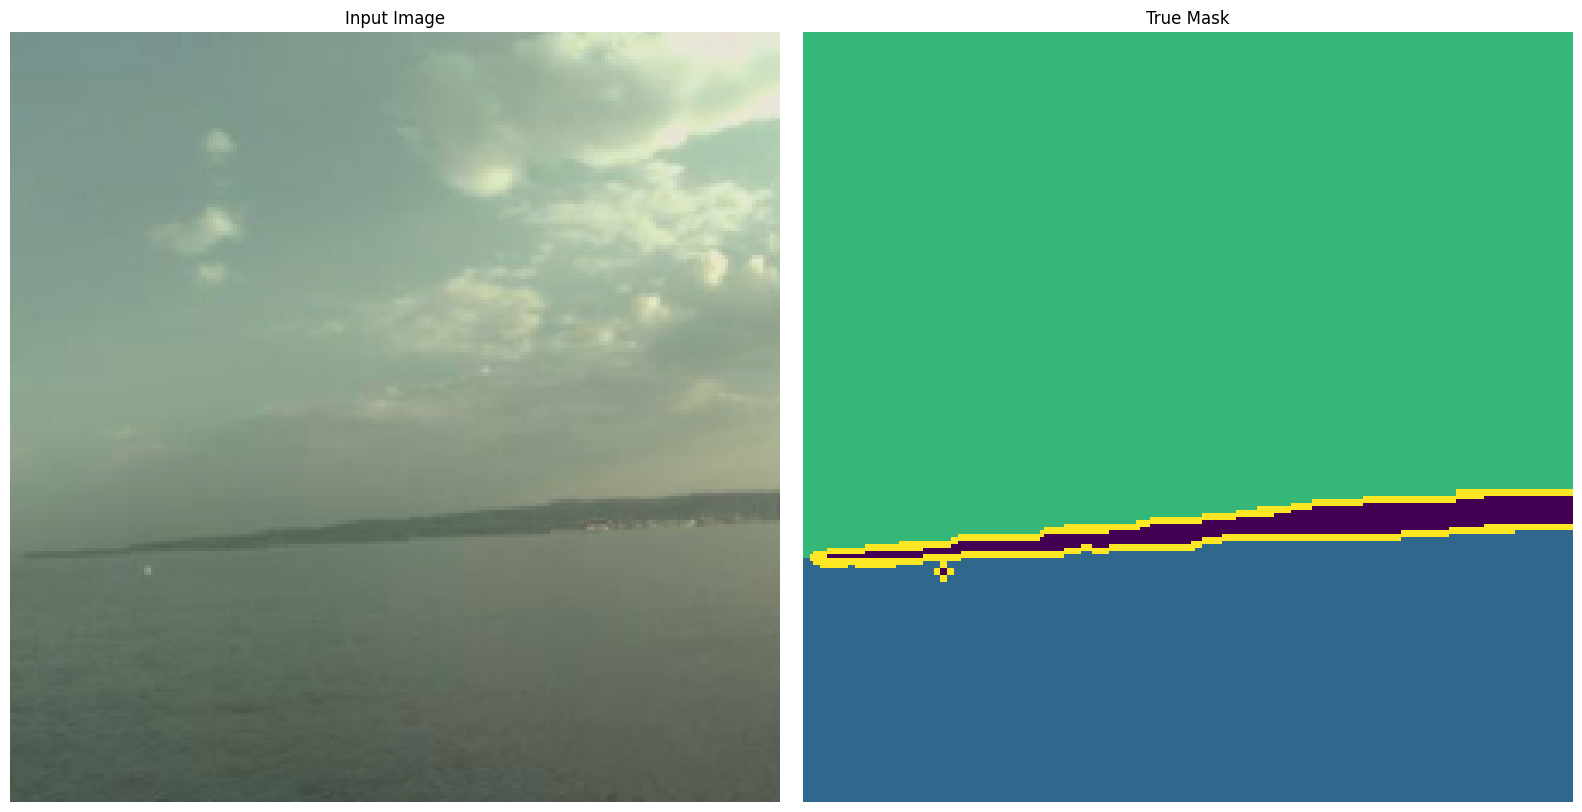

In [ ]:
sample = next(iter(train_dataloader))

imgs, labels = sample['image'], sample['mask']
img_displayer = ImageDisplayer(imgs, labels)
img_displayer.show_sample(idx=0)

## Define Model

In [ ]:
mobileNetWeights = torchvision.models.MobileNet_V2_Weights
mobileNet = torchvision.models.mobilenet_v2(weights=mobileNetWeights)

# remove unused layers
mobileNet.features[-1] = nn.Identity()
mobileNet.classifier = nn.Identity()

# print(mobileNet)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 70.0MB/s]


In [ ]:
feature_extractor = Encoder_feature_extractor(mobileNet)

# dummy forward pass
dummy_input = torch.rand((2, 3, 224, 224))

out = mobileNet(dummy_input)

print(out.shape)

for (key, value) in feature_extractor.features.items():
    print(f'{key}: {value.shape}')

torch.Size([2, 320])
skip_1: torch.Size([2, 96, 112, 112])
skip_2: torch.Size([2, 144, 56, 56])
skip_3: torch.Size([2, 192, 28, 28])
skip_4: torch.Size([2, 576, 14, 14])
skip_5: torch.Size([2, 320, 7, 7])


### UNET definition

In [ ]:
encoder = mobileNet
for param in encoder.parameters():
    param.requires_grad = False
decoder = Unet_MobileNetV2_Decoder()
unet = Unet_MobileNetV2(encoder, decoder)

unet.to(device)
print(device)

cuda:0


In [ ]:
# sum([p.numel() for p in decoder.parameters()])
# print([p for p in unet.decoder.parameters() if p.requires_grad])

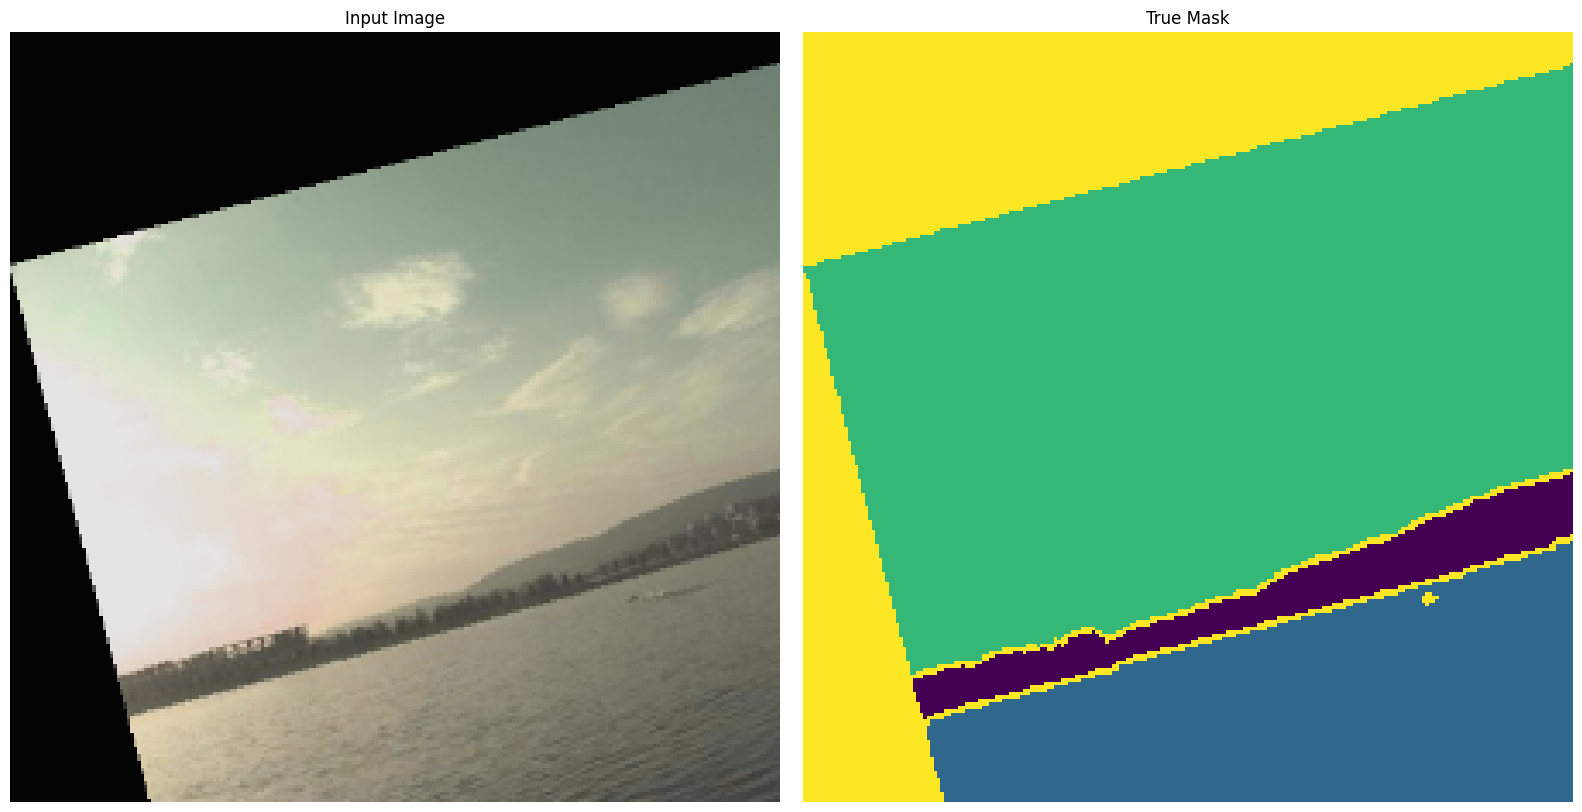

In [ ]:
img_displayer.show_sample(12)

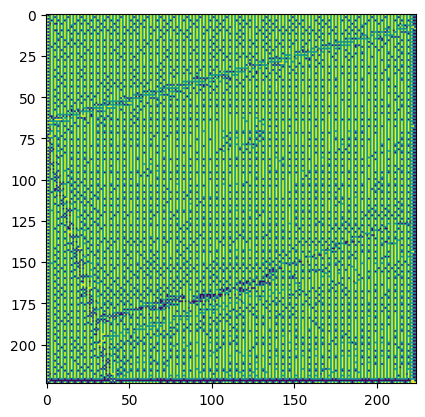

In [ ]:
i = 12
unet.eval()

with torch.no_grad():
  plt.imshow(torch.argmax(unet(imgs[i:i+1].to(device))[0], dim=0).cpu().detach().numpy())

unet.train()
print('')

In [ ]:
# show_features(feature_extractor.features['skip_1'])

In [ ]:
# show_features(feature_extractor.features['skip_2'])

### Loss function definition

In [ ]:
# Testing loss functions

y_pred = torch.tensor([[1, 0, 0], [0.5, 0.5, 0.], [0.5, 0.5, 0], [1, 0, 0]], dtype=float)
y_pred_correct = torch.tensor([[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]], dtype=float)

y_target = torch.tensor([0, 0, 0, 0], dtype=float)
# BCE_loss = nn.functional.cross_entropy(y_pred, y_target)
y_target_one_hot = nn.functional.one_hot(y_target.long(), num_classes=3).float()
BCE_loss = nn.functional.binary_cross_entropy_with_logits(
    y_pred_correct, y_target_one_hot)
focalLoss = torchvision.ops.sigmoid_focal_loss(y_pred, y_target_one_hot, reduction='sum')

print(BCE_loss)
print(focalLoss)

print(y_pred.shape)
print(y_target_one_hot.shape)
# print(torch.sigmoid(y_pred))


# def binary_cross_entropy(input, y): return -(pred.log()*y + (1-y)*(1-pred).log()).mean()


tensor(0.8999)
tensor(1.3910, dtype=torch.float64)
torch.Size([4, 3])
torch.Size([4, 3])


In [ ]:
def Focal_loss(y_true, y_pred):
    mask = torch.where(y_true == 3.0, zeros_like(y_true), ones_like(y_true))

    y_true *= mask
    y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=3).float().permute(0, 3, 1, 2)

    mask = mask.unsqueeze(dim=1)
    y_pred *= mask
    # TODO: double that gradients will not flow through to masked pixels

    loss = torchvision.ops.sigmoid_focal_loss(y_pred, y_true_one_hot, reduction='none')
    loss = (loss * mask).sum() / mask.sum()
    # loss = loss.mean()

    return loss

y_pred = torch.zeros((2, 3, 224, 224))
y_target = torch.randint(0, 4, (2, 224, 224))


loss = Focal_loss(y_target, y_pred)
# loss.backward()
print(loss)



# def sigmoid(x): return (1 + (-x).exp()).reciprocal()

# y_pred = torch.tensor([[[1, 0, 0], [0.5, 0.5, 0.], [0.5, 0.5, 0], [1, 0, 0]]], dtype=float)
# y_target = torch.tensor([[0, 0, 0, 0]], dtype=float)


# def custom_focal_loss(y_true, y_pred):
#     # print(f'y_true: {y_true.shape}')
#     # print(f'y_pred: {y_pred.shape}')
#     y_true_one_hot = nn.functional.one_hot(y_true.long(), num_classes=3).float().permute(0, 3, 1, 2)
#     y_pred = sigmoid(y_pred)

#     # print(y_true_one_hot.shape)
#     # print(y_pred.shape)

#     mask = torch.where(y_true == 3.0, zeros_like(y_true), ones_like(y_true)).unsqueeze(1)

#     return loss




tensor(0.3033)


In [ ]:
unet.to(device)

print(device)


cuda:0


## Train

In [ ]:
history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': [],
}
N_epochs = 100

opt = torch.optim.Adam(unet.parameters())

for epoch in range(N_epochs):
    train_loss = 0.0
    train_accuracy = 0.0
    for item in tqdm(train_dataloader):
        X, y = item['image'], item['mask'].squeeze()

        # TODO: this isn't the most efficient way to load the data into GPU
        y_pred = unet(X)
        opt.zero_grad(set_to_none=True) # to improve performance
        loss = Focal_loss(y, y_pred)
        accuracy = compute_accuracy(y, y_pred)
        loss.backward()
        opt.step()
        # print(loss.item())
        train_loss += loss.item()
        train_accuracy += accuracy.item()
    loss, accuracy = eval_after_epoch(unet, val_dataloader)
    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataloader)
    print(f'Epoch {epoch+1:2d}, Train loss = {train_loss:.5f}, accuracy = {train_accuracy*100:.2f}')
    print(f'     Validation loss = {loss:.5f}, accuracy = {accuracy*100:.2f}')
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(loss)
    history['val_acc'].append(accuracy)


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch  1, Train loss = 0.18456, accuracy = 73.56
     Validation loss = 0.07603, accuracy = 90.12


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch  2, Train loss = 0.04605, accuracy = 94.10
     Validation loss = 0.03174, accuracy = 95.65


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch  3, Train loss = 0.02404, accuracy = 97.31
     Validation loss = 0.02024, accuracy = 97.54


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch  4, Train loss = 0.01656, accuracy = 98.12
     Validation loss = 0.01518, accuracy = 98.16


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch  5, Train loss = 0.01316, accuracy = 98.46
     Validation loss = 0.01301, accuracy = 98.31


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch  6, Train loss = 0.01150, accuracy = 98.60
     Validation loss = 0.01164, accuracy = 98.46


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch  7, Train loss = 0.01015, accuracy = 98.76
     Validation loss = 0.01178, accuracy = 98.39


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch  8, Train loss = 0.00960, accuracy = 98.81
     Validation loss = 0.00969, accuracy = 98.70


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch  9, Train loss = 0.00855, accuracy = 98.92
     Validation loss = 0.00909, accuracy = 98.75


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10, Train loss = 0.00869, accuracy = 98.89
     Validation loss = 0.00835, accuracy = 98.85


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11, Train loss = 0.00816, accuracy = 98.95
     Validation loss = 0.00901, accuracy = 98.77


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12, Train loss = 0.00780, accuracy = 98.97
     Validation loss = 0.00822, accuracy = 98.87


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13, Train loss = 0.00719, accuracy = 99.05
     Validation loss = 0.00791, accuracy = 98.88


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14, Train loss = 0.00659, accuracy = 99.14
     Validation loss = 0.00802, accuracy = 98.86


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15, Train loss = 0.00700, accuracy = 99.06
     Validation loss = 0.00730, accuracy = 98.95


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16, Train loss = 0.00662, accuracy = 99.12
     Validation loss = 0.00768, accuracy = 98.91


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17, Train loss = 0.00623, accuracy = 99.17
     Validation loss = 0.00705, accuracy = 99.00


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18, Train loss = 0.00615, accuracy = 99.17
     Validation loss = 0.00715, accuracy = 98.95


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19, Train loss = 0.00596, accuracy = 99.19
     Validation loss = 0.00666, accuracy = 99.05


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20, Train loss = 0.00582, accuracy = 99.21
     Validation loss = 0.00666, accuracy = 99.02


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 21, Train loss = 0.00571, accuracy = 99.22
     Validation loss = 0.00708, accuracy = 98.99


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 22, Train loss = 0.00549, accuracy = 99.25
     Validation loss = 0.00736, accuracy = 98.95


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 23, Train loss = 0.00533, accuracy = 99.27
     Validation loss = 0.00639, accuracy = 99.06


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 24, Train loss = 0.00507, accuracy = 99.31
     Validation loss = 0.00639, accuracy = 99.07


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 25, Train loss = 0.00525, accuracy = 99.29
     Validation loss = 0.00616, accuracy = 99.09


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 26, Train loss = 0.00495, accuracy = 99.32
     Validation loss = 0.00626, accuracy = 99.09


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 27, Train loss = 0.00494, accuracy = 99.32
     Validation loss = 0.00569, accuracy = 99.15


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 28, Train loss = 0.00483, accuracy = 99.33
     Validation loss = 0.00609, accuracy = 99.10


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 29, Train loss = 0.00468, accuracy = 99.35
     Validation loss = 0.00554, accuracy = 99.16


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 30, Train loss = 0.00482, accuracy = 99.33
     Validation loss = 0.00611, accuracy = 99.07


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 31, Train loss = 0.00461, accuracy = 99.37
     Validation loss = 0.00600, accuracy = 99.12


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 32, Train loss = 0.00475, accuracy = 99.35
     Validation loss = 0.00555, accuracy = 99.15


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 33, Train loss = 0.00467, accuracy = 99.35
     Validation loss = 0.00545, accuracy = 99.17


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 34, Train loss = 0.00465, accuracy = 99.35
     Validation loss = 0.00572, accuracy = 99.12


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 35, Train loss = 0.00528, accuracy = 99.25
     Validation loss = 0.00634, accuracy = 99.02


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 36, Train loss = 0.00528, accuracy = 99.26
     Validation loss = 0.00594, accuracy = 99.15


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 37, Train loss = 0.00475, accuracy = 99.34
     Validation loss = 0.00566, accuracy = 99.18


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 38, Train loss = 0.00441, accuracy = 99.38
     Validation loss = 0.00542, accuracy = 99.19


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 39, Train loss = 0.00453, accuracy = 99.36
     Validation loss = 0.00645, accuracy = 99.03


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 40, Train loss = 0.00457, accuracy = 99.35
     Validation loss = 0.00572, accuracy = 99.14


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 41, Train loss = 0.00451, accuracy = 99.38
     Validation loss = 0.00564, accuracy = 99.14


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 42, Train loss = 0.00425, accuracy = 99.40
     Validation loss = 0.00527, accuracy = 99.20


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 43, Train loss = 0.00418, accuracy = 99.41
     Validation loss = 0.00506, accuracy = 99.24


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 44, Train loss = 0.00402, accuracy = 99.43
     Validation loss = 0.00592, accuracy = 99.11


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 45, Train loss = 0.00512, accuracy = 99.30
     Validation loss = 0.00526, accuracy = 99.19


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 46, Train loss = 0.00548, accuracy = 99.25
     Validation loss = 0.00614, accuracy = 99.07


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 47, Train loss = 0.00448, accuracy = 99.38
     Validation loss = 0.00542, accuracy = 99.17


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 48, Train loss = 0.00440, accuracy = 99.38
     Validation loss = 0.00560, accuracy = 99.13


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 49, Train loss = 0.00468, accuracy = 99.35
     Validation loss = 0.00508, accuracy = 99.23


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 50, Train loss = 0.00410, accuracy = 99.42
     Validation loss = 0.00540, accuracy = 99.19


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 51, Train loss = 0.00404, accuracy = 99.43
     Validation loss = 0.00539, accuracy = 99.18


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 52, Train loss = 0.00406, accuracy = 99.42
     Validation loss = 0.00495, accuracy = 99.22


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 53, Train loss = 0.00389, accuracy = 99.45
     Validation loss = 0.00486, accuracy = 99.25


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 54, Train loss = 0.00376, accuracy = 99.47
     Validation loss = 0.00453, accuracy = 99.31


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 55, Train loss = 0.00359, accuracy = 99.49
     Validation loss = 0.00497, accuracy = 99.22


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 56, Train loss = 0.00387, accuracy = 99.45
     Validation loss = 0.00479, accuracy = 99.26


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 57, Train loss = 0.00395, accuracy = 99.43
     Validation loss = 0.00445, accuracy = 99.31


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 58, Train loss = 0.00381, accuracy = 99.46
     Validation loss = 0.00483, accuracy = 99.24


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 59, Train loss = 0.00350, accuracy = 99.50
     Validation loss = 0.00463, accuracy = 99.28


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 60, Train loss = 0.00377, accuracy = 99.47
     Validation loss = 0.00494, accuracy = 99.23


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 61, Train loss = 0.00374, accuracy = 99.47
     Validation loss = 0.00466, accuracy = 99.26


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 62, Train loss = 0.00349, accuracy = 99.50
     Validation loss = 0.00438, accuracy = 99.32


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 63, Train loss = 0.00348, accuracy = 99.50
     Validation loss = 0.00460, accuracy = 99.27


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 64, Train loss = 0.00348, accuracy = 99.50
     Validation loss = 0.00438, accuracy = 99.30


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 65, Train loss = 0.00356, accuracy = 99.49
     Validation loss = 0.00461, accuracy = 99.28


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 66, Train loss = 0.00352, accuracy = 99.49
     Validation loss = 0.00456, accuracy = 99.30


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 67, Train loss = 0.00345, accuracy = 99.50
     Validation loss = 0.00477, accuracy = 99.25


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 68, Train loss = 0.00362, accuracy = 99.48
     Validation loss = 0.00498, accuracy = 99.20


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 69, Train loss = 0.00338, accuracy = 99.51
     Validation loss = 0.00492, accuracy = 99.21


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 70, Train loss = 0.00333, accuracy = 99.53
     Validation loss = 0.00469, accuracy = 99.26


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 71, Train loss = 0.00324, accuracy = 99.53
     Validation loss = 0.00468, accuracy = 99.27


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 72, Train loss = 0.00340, accuracy = 99.51
     Validation loss = 0.00464, accuracy = 99.28


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 73, Train loss = 0.00328, accuracy = 99.53
     Validation loss = 0.00443, accuracy = 99.30


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 74, Train loss = 0.00335, accuracy = 99.52
     Validation loss = 0.00442, accuracy = 99.29


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 75, Train loss = 0.00332, accuracy = 99.52
     Validation loss = 0.00426, accuracy = 99.33


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 76, Train loss = 0.00334, accuracy = 99.52
     Validation loss = 0.00491, accuracy = 99.20


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 77, Train loss = 0.00324, accuracy = 99.53
     Validation loss = 0.00487, accuracy = 99.24


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 78, Train loss = 0.00321, accuracy = 99.54
     Validation loss = 0.00427, accuracy = 99.32


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 79, Train loss = 0.00353, accuracy = 99.49
     Validation loss = 0.00448, accuracy = 99.30


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 80, Train loss = 0.00319, accuracy = 99.54
     Validation loss = 0.00497, accuracy = 99.20


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 81, Train loss = 0.00310, accuracy = 99.55
     Validation loss = 0.00426, accuracy = 99.32


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 82, Train loss = 0.00314, accuracy = 99.54
     Validation loss = 0.00463, accuracy = 99.26


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 83, Train loss = 0.00319, accuracy = 99.54
     Validation loss = 0.00434, accuracy = 99.30


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 84, Train loss = 0.00322, accuracy = 99.53
     Validation loss = 0.00444, accuracy = 99.29


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 85, Train loss = 0.00363, accuracy = 99.48
     Validation loss = 0.00457, accuracy = 99.30


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 86, Train loss = 0.00352, accuracy = 99.49
     Validation loss = 0.00451, accuracy = 99.28


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 87, Train loss = 0.00340, accuracy = 99.52
     Validation loss = 0.00500, accuracy = 99.21


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 88, Train loss = 0.00319, accuracy = 99.54
     Validation loss = 0.00439, accuracy = 99.30


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 89, Train loss = 0.00328, accuracy = 99.52
     Validation loss = 0.00466, accuracy = 99.26


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 90, Train loss = 0.00351, accuracy = 99.49
     Validation loss = 0.00441, accuracy = 99.27


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 91, Train loss = 0.00313, accuracy = 99.54
     Validation loss = 0.00393, accuracy = 99.37


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 92, Train loss = 0.00305, accuracy = 99.56
     Validation loss = 0.00394, accuracy = 99.37


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 93, Train loss = 0.00301, accuracy = 99.57
     Validation loss = 0.00418, accuracy = 99.32


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 94, Train loss = 0.00301, accuracy = 99.57
     Validation loss = 0.00439, accuracy = 99.31


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 95, Train loss = 0.00351, accuracy = 99.50
     Validation loss = 0.00417, accuracy = 99.35


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 96, Train loss = 0.00420, accuracy = 99.40
     Validation loss = 0.00446, accuracy = 99.31


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 97, Train loss = 0.00327, accuracy = 99.53
     Validation loss = 0.00420, accuracy = 99.34


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 98, Train loss = 0.00292, accuracy = 99.58
     Validation loss = 0.00418, accuracy = 99.34


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 99, Train loss = 0.00297, accuracy = 99.57
     Validation loss = 0.00423, accuracy = 99.33


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 100, Train loss = 0.00293, accuracy = 99.58
     Validation loss = 0.00409, accuracy = 99.35


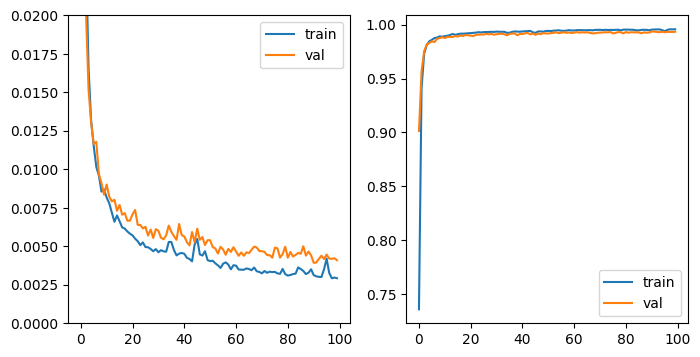

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.ylim((0.00, 0.02))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='val')
plt.legend()


## Dropout

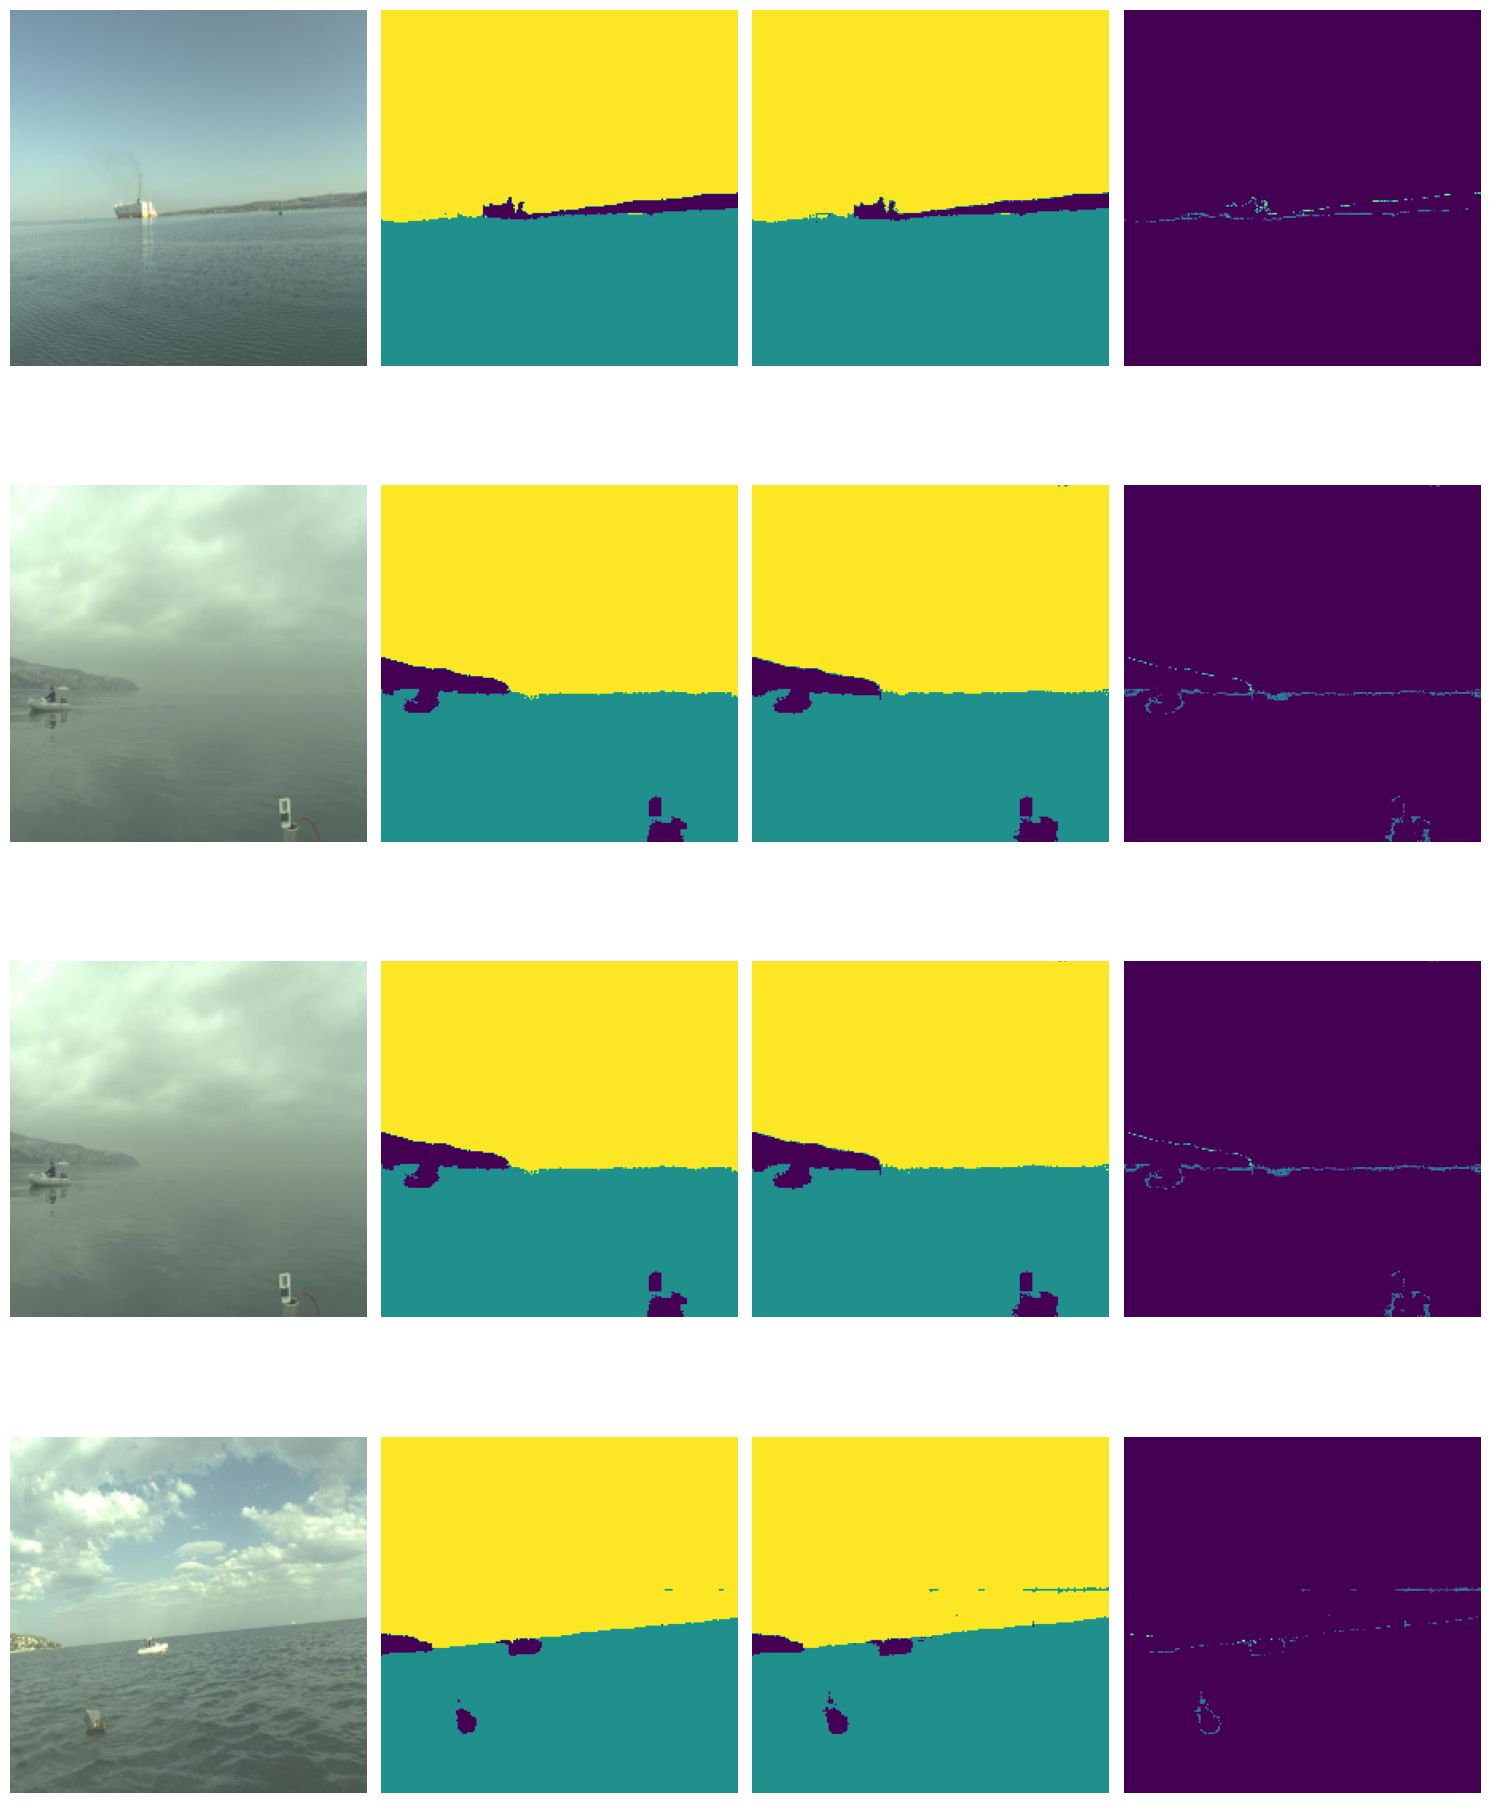

In [ ]:
def bayes_forward(model, X, n):
    # calculate loss & accuracy on validation set
    loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
        model.eval()
        for m in model.modules():
          if m.__class__.__name__.startswith('Dropout'):
            m.train()
        model.decoder.block_1[2].p = 0.5
        model.decoder.block_2[2].p = 0
        model.decoder.block_3[2].p = 0
        model.decoder.block_4[2].p = 0

        X_repeat = X.unsqueeze(0).repeat(n, 1, 1, 1)
        y_pred = model(X_repeat)

    model.decoder.block_1[2].p = 0.5
    model.decoder.block_2[2].p = 0.5
    model.decoder.block_3[2].p = 0.5
    model.decoder.block_4[2].p = 0.5

    model.train()
    return y_pred

def regular_forward(model, X):
    # calculate loss & accuracy on validation set
    loss = 0.0
    accuracy = 0.0

    model.eval()
    with torch.no_grad():
        y_pred = torch.argmax(model(X.unsqueeze(0)), 1).squeeze()

    model.train()

    return y_pred
# y_pred_mean = y_pred.mean(dim=0)
# y_pred_sigma = y_pred.std(dim=0)

# y_mean = torch.argmax(y_pred_mean, dim=0)
# y_sigma = torch.sum(y_pred_sigma, dim=0)

plt.figure(figsize=(15, 20))

for i in range(4):
  item = next(iter(val_dataloader))
  X, y = item['image'], item['mask'].squeeze(dim=1)
  y_pred = bayes_forward(unet, X[0], n=40)

  y_pred = torch.argmax(y_pred, dim=1).to(torch.float)

  y_mean = y_pred.mean(dim=0).to(torch.int)
  y_sigma = y_pred.std(dim=0)

  plt.subplot(4, 4, 1+i*4)
  plt.imshow(X[0].permute(1, 2, 0).cpu())
  plt.axis('off')

  y_pred_noDropout = regular_forward(unet, X[0])
  plt.subplot(4, 4, 2+i*4)
  plt.imshow(y_pred_noDropout.cpu())
  plt.axis('off')

  plt.subplot(4, 4, 3+i*4)
  plt.imshow(y_mean.cpu())
  plt.axis('off')

  plt.subplot(4, 4, 4+i*4)
  plt.imshow(y_sigma.cpu())
  plt.axis('off')

plt.tight_layout()